## TODO

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training (https://www.kaggle.com/alessiocorrado99/animals10)

In [1]:
import numpy as np 
import pandas as pd 

import os

In [2]:
!pip install jovian --upgrade --quiet
import jovian

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split, Dataset
# from translate.py import translate
import torchvision.models as models

import random
%matplotlib inline

In [4]:
project_name = "animal-classification"

In [5]:
!pip install opendatasets --upgrade --quiet



### Download the Dataset

Using `opendatasets` and download the datasat from (https://www.kaggle.com/alessiocorrado99/animals10)

In [6]:
import opendatasets as od

In [7]:
dataset_url = 'https://www.kaggle.com/alessiocorrado99/animals10'

In [8]:
import os
import shutil

if os.path.exists('./animals10/raw-img'):
    shutil.rmtree('./animals10/raw-img')

In [9]:
od.download(dataset_url)

  3%|▎         | 17.0M/586M [00:00<00:03, 168MB/s]

100%|██████████| 586M/586M [00:02<00:00, 269MB/s]


In [10]:
data_dir = './animals10/raw-img'

### Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.


In [11]:
from torchvision.datasets import ImageFolder

In [12]:
dataset = ImageFolder(data_dir)

In [13]:
len(dataset)

26179

In [15]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

In [16]:
def show(img, label):
    print('Label:', dataset.classes[label], '(' + str(label)+')')
    plt.imshow(img.permute(1,2,0))

Label: cane (0)


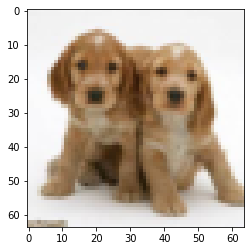

In [17]:
show(*dataset[random.randint(1,len(dataset))])

In [18]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(23562, 2617)

In [19]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)


(23562, 2617)

In [20]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=2, 
                    pin_memory=True)


In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

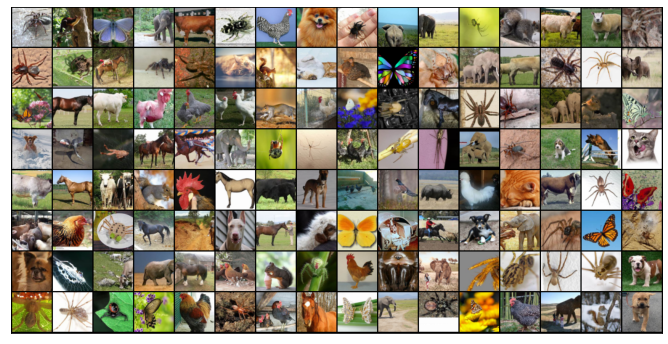

In [22]:
show_batch(train_dl)

### GPU Utilities

In [23]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
torch.cuda.is_available()

True

In [25]:
device = get_default_device()

In [26]:
device

device(type='cuda')

In [27]:
img, label = dataset[0]

In [28]:
img.device

device(type='cpu')

In [29]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilties

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [33]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [34]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [35]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [36]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 10])


### Training the Model

In [37]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.07226399332284927, 'val_loss': 2.3060219287872314}]

In [38]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.7656, val_loss: 1.3181, val_acc: 0.5587
Epoch [1], train_loss: 1.2337, val_loss: 1.7205, val_acc: 0.4645
Epoch [2], train_loss: 0.9888, val_loss: 1.1118, val_acc: 0.6533
Epoch [3], train_loss: 0.8058, val_loss: 1.4296, val_acc: 0.6057
Epoch [4], train_loss: 0.7046, val_loss: 1.0353, val_acc: 0.6807


In [39]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4629, val_loss: 0.5196, val_acc: 0.8301
Epoch [1], train_loss: 0.4121, val_loss: 0.4864, val_acc: 0.8385
Epoch [2], train_loss: 0.3819, val_loss: 0.4430, val_acc: 0.8580
Epoch [3], train_loss: 0.3433, val_loss: 0.4526, val_acc: 0.8481
Epoch [4], train_loss: 0.3160, val_loss: 0.4615, val_acc: 0.8491


In [45]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2805, val_loss: 0.4196, val_acc: 0.8592
Epoch [1], train_loss: 0.2669, val_loss: 0.4072, val_acc: 0.8605
Epoch [2], train_loss: 0.2730, val_loss: 0.4159, val_acc: 0.8671
Epoch [3], train_loss: 0.2704, val_loss: 0.4130, val_acc: 0.8566
Epoch [4], train_loss: 0.2652, val_loss: 0.4062, val_acc: 0.8605


## Visualizing the Evaluation 

In [46]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

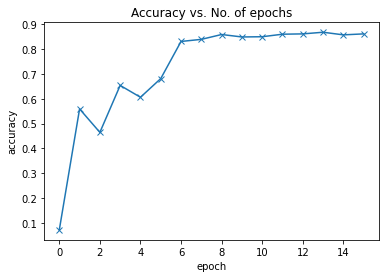

In [47]:
plot_accuracies(history)

In [48]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

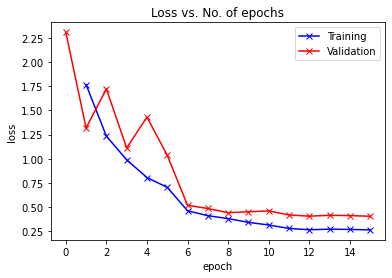

In [49]:
plot_losses(history)

### Test with Individual Images

In [50]:
history[-1]

{'train_loss': 0.2652234435081482,
 'val_acc': 0.860504150390625,
 'val_loss': 0.40618956089019775}

In [53]:
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

In [54]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: ragno
Prediction: ragno


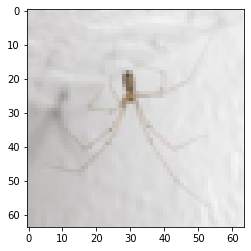

In [55]:
show_image_prediction(*valid_ds[100])

Target: farfalla
Prediction: farfalla


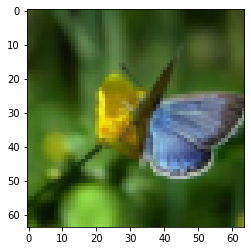

In [56]:
show_image_prediction(*valid_ds[300])

Target: gallina
Prediction: gallina


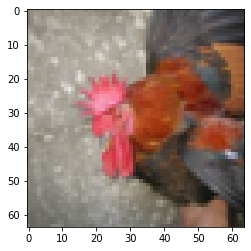

In [57]:
show_image_prediction(*valid_ds[12])

In [60]:
torch.save(model.state_dict(), 'Animals-Prediction-resnet9.pth')